# Evaluate Performance of RAG vs. Non-RAG
In this notebook, we will be assessing the performance of RAG vs. Non-RAG for the application by calculating the cosing similarity between the expected image caption and the captions generated with RAG and without RAG.

In [42]:
import openai as OpenAI
from transformers import BertModel, BertTokenizer
import torch
from dotenv import load_dotenv
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

### Evaluation Data

In [43]:
# generate sample data for testing
test_query_1 = "Daniel, Santiago, Pipe, and Kika wearing Michigan gear"
test_query_2 = "Daniel enjoying beers with Azul, Javier, Julio, Will, and Pablo in Ann Arbor"
test_query_3 = "Daniel, Santiago, Juan, Graciela, and Pipe hiking in Mount Rainier"
test_query_4 = "Julio and Azul enjoying a drink in Ann Arbor"
test_query_5 = "Daniel and Sri celebrating a Duke Football win"
test_query_6 = "Santiago and Graciela having lunch in Seattle, Washington"
test_query_7 = "Daniel, Santiago, and Will enjoying a ski day in Mount Holly, Michigan"
test_query_8 = "Santiago and Julio having dinner and drinking wine in Ann Arbor"
test_query_9 = "Javier, Santiago, Daniel, and Julio dressed up on their way to a Gala in Ann Arbor"
test_query_10 = "Juan, Graciela, Santiago, and Daniel at Santiago's graduation from the University of Michigan"

queries = [test_query_1, test_query_2, test_query_3, test_query_4, test_query_5, test_query_6, test_query_7, test_query_8, test_query_9, test_query_10]


In [44]:
true_caption_1 = "Daniel, Santiago, Pipe, are are enjoying an evening with their grandmother, Kika, watching the Michigan game vs. Alabama. Go Blue!"
true_caption_2 = "Daniel, Julio, Will, Pablo and Javier enjoy their beers in a chilly night in Ann Arbor at Bills Beer Garden. The feeling of comraderie and friendship is palpable amongst them."
true_caption_3 = "Daniel, Santiago, Juan, Graciela, and Pipe pose behind a breathtaking snowy mountaintop in Seattle, Washington. They are enjoying their vacation as a happy family."
true_caption_4 = "Julio and Azul are having a good time as they both sip from a fishbowl at Charley's in Ann Arbor. The two friends are enjoying their time together."
true_caption_5 = "Daniel and Sri ecstatic as the scoreboard behind them spells 'Duke Wins!'. They are jubilant as they pose on the field celebrating a Duke Football win in Durham, North Carolina."
true_caption_6 = "Santiago and his mom, Graciela, enjoy a delicious lunch in Seattle, Washington. Graciela flew in from Colomgia to help her son move in. They smile as they enjoy the food and drinks together."
true_caption_7 = "Daniel, Santiago, and Will are all smiles as they pose for a picture after a day of skiing at Mount Holly, Michigan. The three friends are enjoying their time together."
true_caption_8 = "Santiago and Julio enjoy a delicious dinner at Mani in Ann Arbor. They are having glasses of red wine and a delicious meal together."
true_caption_9 = "Javier, Santiago, Daniel, and Julio are all dressed up and ready to go to the Gala in Ann Arbor. They are all smiles as they pose for a picture."
true_caption_10 = "Juan, Graciela, Santiago, and Daniel are all smiles as they pose for a picture at Santiago's graduation from the University of Michigan. They are all proud of Santiago's accomplishment."

true_captions = [true_caption_1, true_caption_2, true_caption_3, true_caption_4, true_caption_5, true_caption_6, true_caption_7, true_caption_8, true_caption_9, true_caption_10]

### Generate Response without RAG

In [45]:
def generate_no_rag_response(query):
    """
    Generates an openai response to a given query
    Input: query
    Output: response
    """
    load_dotenv()
    client = OpenAI.Client(api_key=os.getenv('OPENAI_API_KEY'))
    client = OpenAI.Client(api_key=os.getenv('OPENAI_API_KEY'))

    context = "Generate a relevant caption for the following moment:"

    try:
        completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": context},
            {"role": "user", "content": query}
            ]
        )
        # Get the response from the completion
        response = completion.choices[0].message.content

        # Check if the reply is empty, indicating the question may be out of context
        if not response:
            response = "I am sorry, but I am not equipped to respond to that query."
    except Exception as e:
        print("Failed to generate response.")
        print(e)
    
    return response


### Generate Response with RAG

In [46]:
def generate_rag_response(query):
    """
    Makes a call to RAG Flask app to get the image description that matches the query the most.
    Input: query
    Output: The text of the last image description in the response.
    """
    url = "http://127.0.0.1:5000/get_images"
    headers = {
        "Content-Type": "application/json"
    }
    data = {
        "query": query
    }

    response = requests.post(url, json=data, headers=headers)
    response_json = response.json()

    # Assuming the response structure is {'response': {...}}
    descriptions = response_json.get('response', {})

    # Getting the last description's text
    last_key = list(descriptions.keys())[-1]  # Get the last key
    last_description = descriptions[last_key]  # Get the description for the last key

    return last_description

## Evaluation Pipeline

In [47]:
def embed_query(query):
    """
    Encodes a query using BERT tokenizer
    Input: list of queries
    Output: list of encoded queries
    """
    # Load the BERT model and tokenizer
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Tokenize the query
    tokenized_query = tokenizer(query, padding=True, truncation=True, return_tensors='pt')

    # Embed the query
    with torch.no_grad():
        outputs = model(**tokenized_query)
    
    # Extract the last hidden states
    last_hidden_states = outputs.last_hidden_state

    # Take the mean of the last hidden states
    mean_embedding = torch.mean(last_hidden_states, dim=1).tolist()[0]

    return mean_embedding

In [48]:
def cosine_sim(embedding_1, embedding_2):
    """
    Calculates the cosine similarity between two embeddings
    Input: two embeddings
    Output: cosine similarity
    """
    # Calculate the dot product
    dot_product = sum([a*b for a, b in zip(embedding_1, embedding_2)])
    # Calculate the magnitude of each vector
    magnitude_1 = sum([a**2 for a in embedding_1]) ** 0.5
    magnitude_2 = sum([a**2 for a in embedding_2]) ** 0.5

    # Calculate the cosine similarity
    cosine_similarity = dot_product / (magnitude_1 * magnitude_2)

    return cosine_similarity

In [49]:
def get_similarity_scores(queries, true_captions):
    """
    Calculate the cosine similarity between captions generated by OpenAI without RAG and true captions.
    Calculate the cosine similarity between captions generated by OpenAI with RAG and true captions.
    Input: list of queries, list of true captions
    Output: cosine similarity scores
    """
    # generate responses without rag
    no_rag_responses = [generate_no_rag_response(query) for query in queries]
    # embed no_rag_responses
    no_rag_embeddings = [embed_query(response) for response in no_rag_responses]

    # generate responses with rag
    rag_responses = [generate_rag_response(query) for query in queries]
    # embed rag_responses
    rag_embeddings = [embed_query(response) for response in rag_responses]

    # embed true captions
    true_caption_embeddings = [embed_query(caption) for caption in true_captions]

    # calculate cosine similarity between no_rag_responses and true_captions
    no_rag_scores = [cosine_sim(embedding, true_caption_embeddings[i]) for i, embedding in enumerate(no_rag_embeddings)]

    # calculate cosine similarity between rag_responses and true_captions
    rag_scores = [cosine_sim(embedding, true_caption_embeddings[i]) for i, embedding in enumerate(rag_embeddings)]

    return no_rag_scores, rag_scores

In [50]:
no_rag_scores, rag_scores = get_similarity_scores(queries, true_captions)

## Analyze Results

In [51]:
def perform_welchs_t_test(no_rag_scores, rag_scores):
    # Perform Welch's t-test
    t_statistic, p_value = stats.ttest_ind(no_rag_scores, rag_scores, equal_var=False)
    
    print("Welch's t-test results:")
    print(f"t-statistic: {t_statistic:.3f}, p-value: {p_value:.3f}")
    
    # Interpret the significance
    alpha = 0.05  # Common threshold for significance
    if p_value < alpha:
        print("The difference in means between the two groups is statistically significant.")
    else:
        print("The difference in means between the two groups is not statistically significant.")

In [58]:
def evaluation(no_rag_scores, rag_scores):

    # Calculate basic statistics
    no_rag_mean = np.mean(no_rag_scores)
    rag_mean = np.mean(rag_scores)

    no_rag_median = np.median(no_rag_scores)
    rag_median = np.median(rag_scores)

    # Print statistics
    print("No RAG Scores - Mean: {:.2f}, Median: {:.2f}".format(no_rag_mean, no_rag_median))
    print("RAG Scores - Mean: {:.2f}, Median: {:.2f}".format(rag_mean, rag_median))
    perform_welchs_t_test(no_rag_scores, rag_scores)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(no_rag_scores, alpha=0.5, label='No RAG Scores')
    plt.hist(rag_scores, alpha=0.5, label='RAG Scores')
    plt.title('Comparison of Cosine Similarity Scores')
    plt.xlabel('Cosine Similarity Score')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

No RAG Scores - Mean: 0.73, Median: 0.74
RAG Scores - Mean: 0.83, Median: 0.84
Welch's t-test results:
t-statistic: -5.491, p-value: 0.000
The difference in means between the two groups is statistically significant.


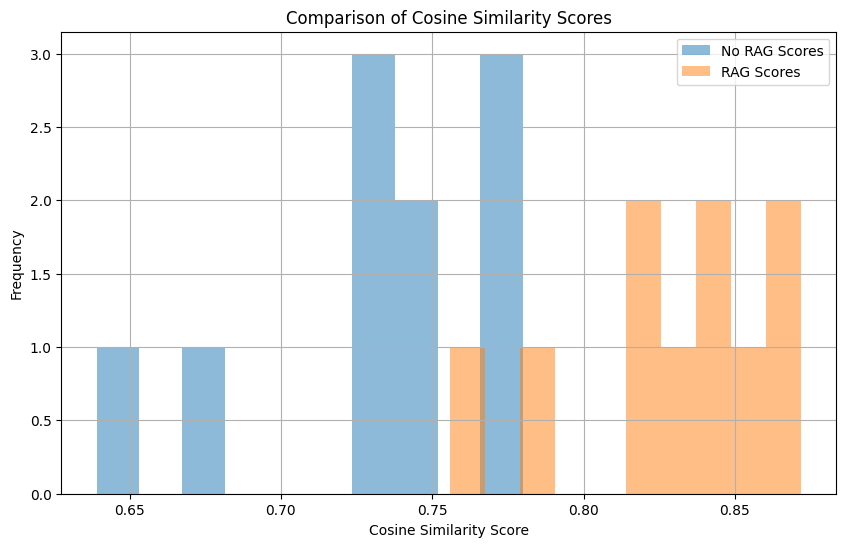

In [59]:
evaluation(no_rag_scores, rag_scores)